StatementMeta(, 8e3f96e2-4681-4727-bb31-88e63879d6ef, 3, Finished, Available, Finished)

CROSS-DOMAIN ANALYSIS: MOBILITY vs AIR QUALITY (2019-2024)

Analyzing Daily Correlation: Taxi Trips vs Air Quality...
Matched 744 days with both mobility and air quality data

Correlation Coefficient:
   Trips vs PM2.5: 0.116


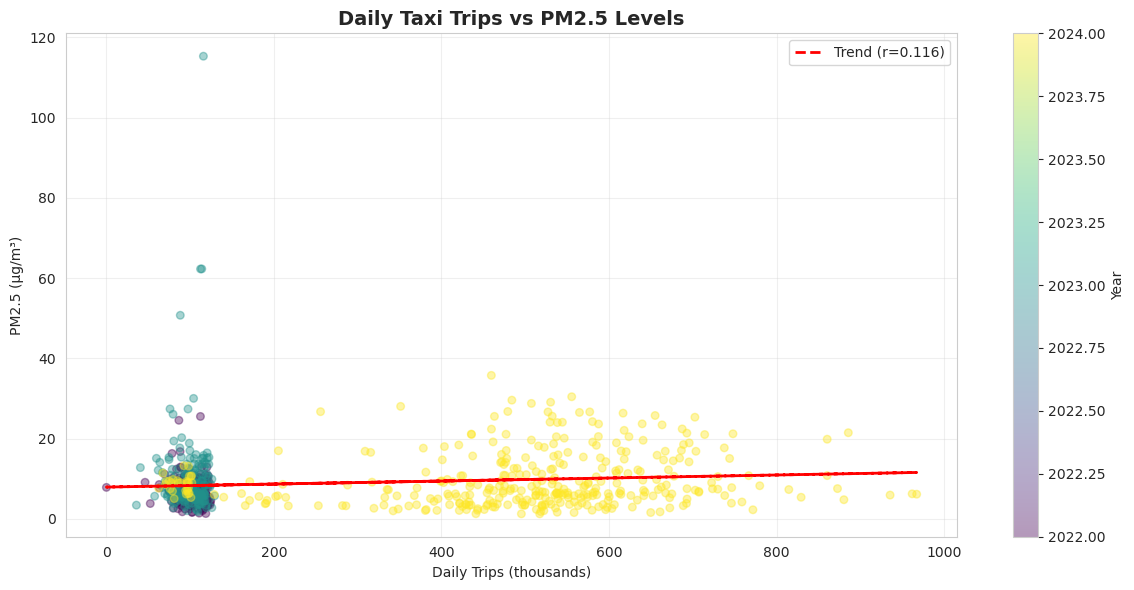


Time Series Overlay: Trips vs Pollution...


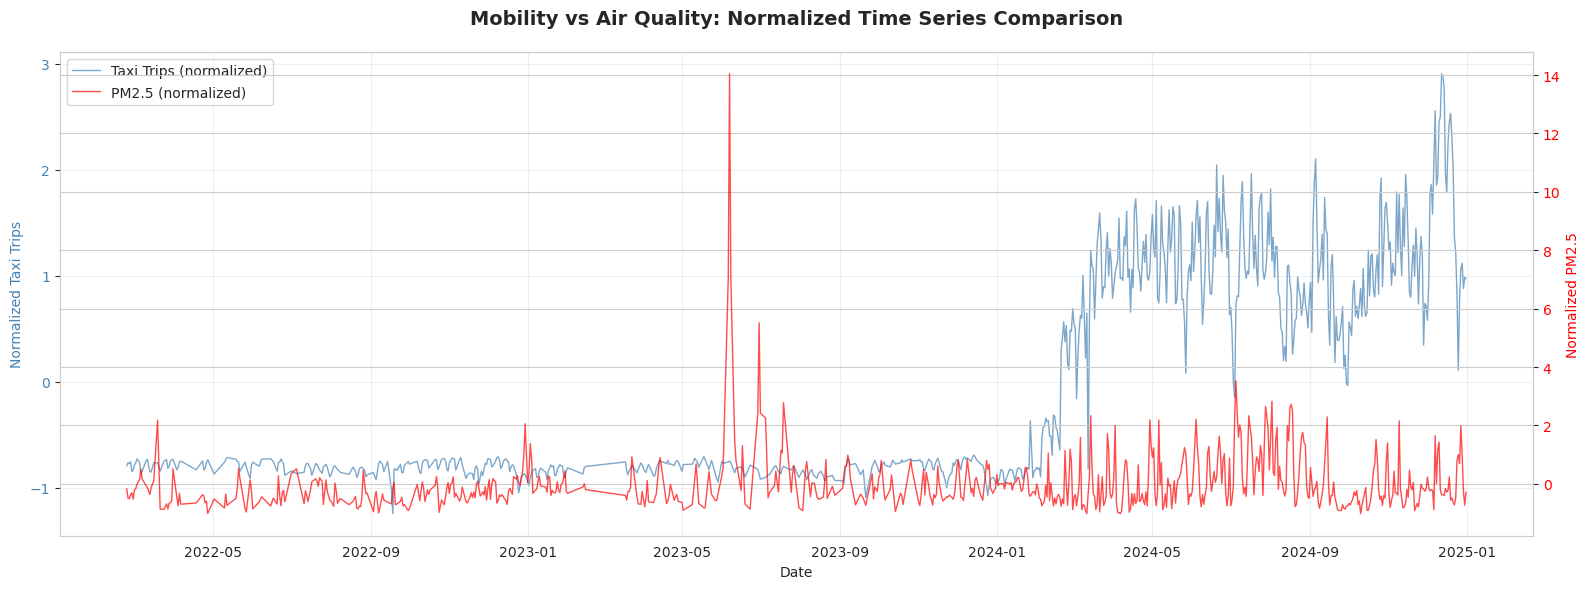


Weekday vs Weekend Impact on Air Quality...


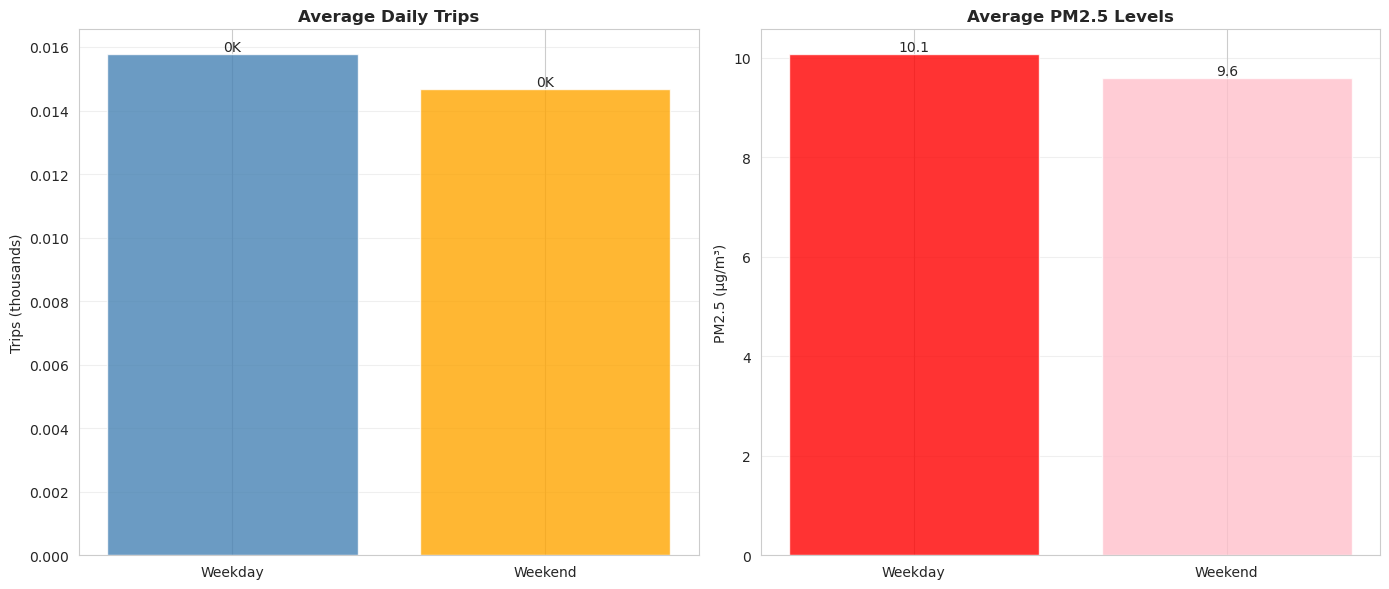


Weekday vs Weekend Summary:
DayType  AvgDailyTrips   AvgPM25
Weekday      15.767699 10.063906
Weekend      14.692932  9.587453

Yearly Trends: Mobility vs Air Quality...


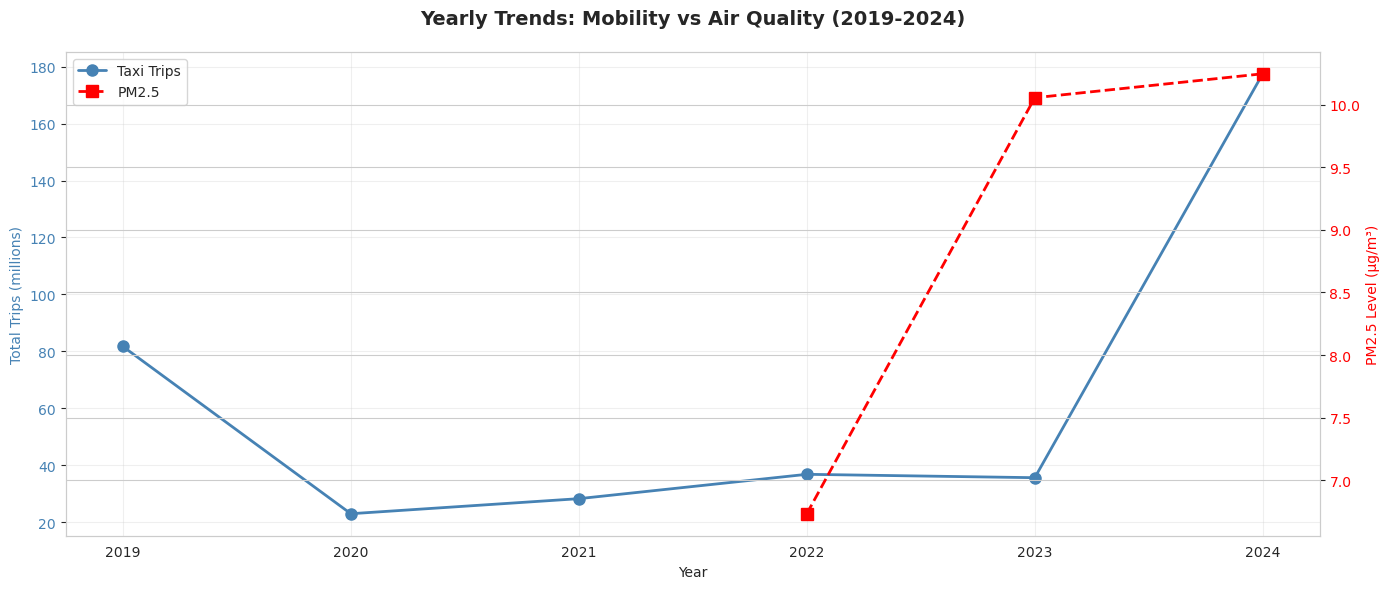


Yearly Comparison:
 Year  TotalTrips   AvgPM25
 2019  81699116.0       NaN
 2020  22942488.0       NaN
 2021  28233349.0       NaN
 2022  36790115.0  6.733794
 2023  35600827.0 10.054832
 2024 177512332.0 10.246149

COVID-19 Impact: Mobility and Air Quality...


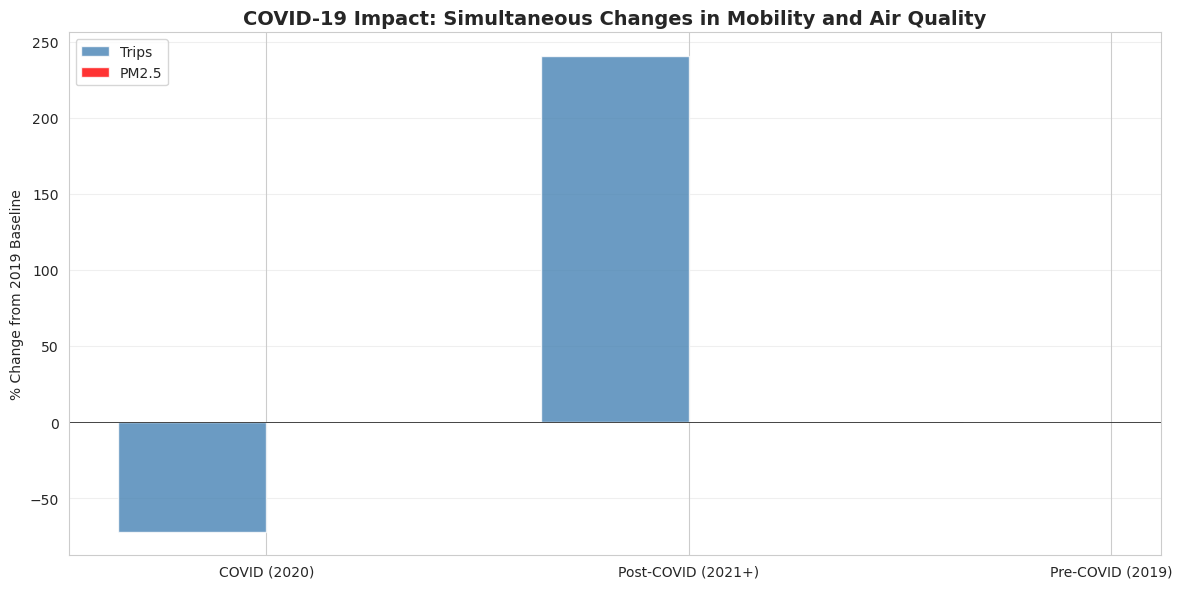


COVID Impact Summary:
            Period  TotalTrips  AvgPM25  Trips_Change  PM25_Change
      COVID (2020)  22942488.0      NaN    -71.918315          NaN
Post-COVID (2021+) 278136623.0 9.932762    240.440187          NaN
  Pre-COVID (2019)  81699116.0      NaN      0.000000          NaN
KEY FINDINGS: MOBILITY vs AIR QUALITY

Statistical Correlations:
   Trips vs PM2.5: r = 0.116
   → Weak correlation between taxi trips and PM2.5

COVID-19 Impact (2019 → 2020):
   Taxi trips dropped: -71.9%
   PM2.5 changed: +nan%
CROSS-DOMAIN CORRELATION ANALYSIS COMPLETE


In [1]:
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats

WAREHOUSE = "MobilityWarehouse"

print("CROSS-DOMAIN ANALYSIS: MOBILITY vs AIR QUALITY (2019-2024)")

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

print("\nAnalyzing Daily Correlation: Taxi Trips vs Air Quality...")

df_correlation = spark.sql(f"""
    SELECT 
        d.Date,
        d.Year,
        d.DayOfWeek,
        d.IsWeekend,
        SUM(t.TripCount) as DailyTrips,
        AVG(t.AvgFareAmount) as AvgFare,
        AVG(aq.AvgPM25) as PM25
    FROM `{WAREHOUSE}`.dbo.DimDate d
    LEFT JOIN `{WAREHOUSE}`.dbo.FactTaxiDaily t ON d.DateKey = t.DateKey
    LEFT JOIN `{WAREHOUSE}`.dbo.FactAirQualityDaily aq ON d.DateKey = aq.DateKey
    WHERE d.Year BETWEEN 2019 AND 2024
    GROUP BY d.Date, d.Year, d.DayOfWeek, d.IsWeekend
    HAVING SUM(t.TripCount) IS NOT NULL AND AVG(aq.AvgPM25) IS NOT NULL
    ORDER BY d.Date
""")

pdf_corr = df_correlation.toPandas()
pdf_corr['Date'] = pd.to_datetime(pdf_corr['Date'])

for col in ['DailyTrips', 'AvgFare', 'PM25']:
    pdf_corr[col] = pdf_corr[col].astype(float)

print(f"Matched {len(pdf_corr):,} days with both mobility and air quality data")

corr_pm25 = pdf_corr['DailyTrips'].corr(pdf_corr['PM25'])

print(f"\nCorrelation Coefficient:")
print(f"   Trips vs PM2.5: {corr_pm25:.3f}")

fig, ax = plt.subplots(figsize=(12, 6))

sc = ax.scatter(pdf_corr['DailyTrips']/1000, pdf_corr['PM25'], 
                alpha=0.4, s=30, c=pdf_corr['Year'], cmap='viridis')
z = np.polyfit(pdf_corr['DailyTrips']/1000, pdf_corr['PM25'], 1)
p = np.poly1d(z)
ax.plot(pdf_corr['DailyTrips']/1000, p(pdf_corr['DailyTrips']/1000), 
        "r--", linewidth=2, label=f'Trend (r={corr_pm25:.3f})')
ax.set_title('Daily Taxi Trips vs PM2.5 Levels', fontsize=14, fontweight='bold')
ax.set_xlabel('Daily Trips (thousands)')
ax.set_ylabel('PM2.5 (µg/m³)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.colorbar(sc, label='Year', ax=ax)

plt.tight_layout()
plt.show()

print("\nTime Series Overlay: Trips vs Pollution...")

pdf_corr['Trips_Normalized'] = (pdf_corr['DailyTrips'] - pdf_corr['DailyTrips'].mean()) / pdf_corr['DailyTrips'].std()
pdf_corr['PM25_Normalized'] = (pdf_corr['PM25'] - pdf_corr['PM25'].mean()) / pdf_corr['PM25'].std()

fig, ax1 = plt.subplots(figsize=(16, 6))

ax1.plot(pdf_corr['Date'], pdf_corr['Trips_Normalized'], 
         color='steelblue', alpha=0.7, linewidth=1, label='Taxi Trips (normalized)')
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Taxi Trips', color='steelblue')
ax1.tick_params(axis='y', labelcolor='steelblue')
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
ax2.plot(pdf_corr['Date'], pdf_corr['PM25_Normalized'], 
         color='red', alpha=0.7, linewidth=1, label='PM2.5 (normalized)')
ax2.set_ylabel('Normalized PM2.5', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Mobility vs Air Quality: Normalized Time Series Comparison', 
          fontsize=14, fontweight='bold', pad=20)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()

print("\nWeekday vs Weekend Impact on Air Quality...")

df_weekend_aq = spark.sql(f"""
    SELECT 
        CASE WHEN d.IsWeekend = 1 THEN 'Weekend' ELSE 'Weekday' END as DayType,
        AVG(t.TripCount) as AvgDailyTrips,
        AVG(aq.AvgPM25) as AvgPM25
    FROM `{WAREHOUSE}`.dbo.DimDate d
    LEFT JOIN `{WAREHOUSE}`.dbo.FactTaxiDaily t ON d.DateKey = t.DateKey
    LEFT JOIN `{WAREHOUSE}`.dbo.FactAirQualityDaily aq ON d.DateKey = aq.DateKey
    WHERE d.Year BETWEEN 2019 AND 2024
    GROUP BY CASE WHEN d.IsWeekend = 1 THEN 'Weekend' ELSE 'Weekday' END
""")

pdf_weekend_aq = df_weekend_aq.toPandas()
for col in ['AvgDailyTrips', 'AvgPM25']:
    pdf_weekend_aq[col] = pdf_weekend_aq[col].astype(float)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].bar(pdf_weekend_aq['DayType'], pdf_weekend_aq['AvgDailyTrips']/1000, 
            color=['steelblue', 'orange'], alpha=0.8)
axes[0].set_title('Average Daily Trips', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Trips (thousands)')
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(pdf_weekend_aq['AvgDailyTrips']/1000):
    axes[0].text(i, v, f'{v:.0f}K', ha='center', va='bottom')

axes[1].bar(pdf_weekend_aq['DayType'], pdf_weekend_aq['AvgPM25'], 
            color=['red', 'pink'], alpha=0.8)
axes[1].set_title('Average PM2.5 Levels', fontsize=12, fontweight='bold')
axes[1].set_ylabel('PM2.5 (µg/m³)')
axes[1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(pdf_weekend_aq['AvgPM25']):
    axes[1].text(i, v, f'{v:.1f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("\nWeekday vs Weekend Summary:")
print(pdf_weekend_aq.to_string(index=False))

print("\nYearly Trends: Mobility vs Air Quality...")

df_yearly_both = spark.sql(f"""
    SELECT 
        d.Year,
        SUM(t.TripCount) as TotalTrips,
        AVG(aq.AvgPM25) as AvgPM25
    FROM `{WAREHOUSE}`.dbo.DimDate d
    LEFT JOIN `{WAREHOUSE}`.dbo.FactTaxiDaily t ON d.DateKey = t.DateKey
    LEFT JOIN `{WAREHOUSE}`.dbo.FactAirQualityDaily aq ON d.DateKey = aq.DateKey
    WHERE d.Year BETWEEN 2019 AND 2024
    GROUP BY d.Year
    ORDER BY d.Year
""")

pdf_yearly_both = df_yearly_both.toPandas()
for col in ['TotalTrips', 'AvgPM25']:
    pdf_yearly_both[col] = pdf_yearly_both[col].astype(float)

fig, ax1 = plt.subplots(figsize=(14, 6))

color = 'steelblue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Total Trips (millions)', color=color)
ax1.plot(pdf_yearly_both['Year'], pdf_yearly_both['TotalTrips']/1e6, 
         color=color, marker='o', linewidth=2, markersize=8, label='Taxi Trips')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
color = 'red'
ax2.set_ylabel('PM2.5 Level (µg/m³)', color=color)
ax2.plot(pdf_yearly_both['Year'], pdf_yearly_both['AvgPM25'], 
         color='red', marker='s', linewidth=2, markersize=8, label='PM2.5', linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Yearly Trends: Mobility vs Air Quality (2019-2024)', 
          fontsize=14, fontweight='bold', pad=20)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()

print("\nYearly Comparison:")
print(pdf_yearly_both.to_string(index=False))

print("\nCOVID-19 Impact: Mobility and Air Quality...")

df_covid_both = spark.sql(f"""
    SELECT 
        CASE 
            WHEN d.Year = 2019 THEN 'Pre-COVID (2019)'
            WHEN d.Year = 2020 THEN 'COVID (2020)'
            ELSE 'Post-COVID (2021+)'
        END as Period,
        SUM(t.TripCount) as TotalTrips,
        AVG(aq.AvgPM25) as AvgPM25
    FROM `{WAREHOUSE}`.dbo.DimDate d
    LEFT JOIN `{WAREHOUSE}`.dbo.FactTaxiDaily t ON d.DateKey = t.DateKey
    LEFT JOIN `{WAREHOUSE}`.dbo.FactAirQualityDaily aq ON d.DateKey = aq.DateKey
    GROUP BY CASE 
        WHEN d.Year = 2019 THEN 'Pre-COVID (2019)'
        WHEN d.Year = 2020 THEN 'COVID (2020)'
        ELSE 'Post-COVID (2021+)'
    END
    ORDER BY Period
""")

pdf_covid_both = df_covid_both.toPandas()
for col in ['TotalTrips', 'AvgPM25']:
    pdf_covid_both[col] = pdf_covid_both[col].astype(float)

baseline_trips = pdf_covid_both[pdf_covid_both['Period'] == 'Pre-COVID (2019)']['TotalTrips'].iloc[0]
baseline_pm25 = pdf_covid_both[pdf_covid_both['Period'] == 'Pre-COVID (2019)']['AvgPM25'].iloc[0]

pdf_covid_both['Trips_Change'] = ((pdf_covid_both['TotalTrips'] - baseline_trips) / baseline_trips * 100)
pdf_covid_both['PM25_Change'] = ((pdf_covid_both['AvgPM25'] - baseline_pm25) / baseline_pm25 * 100)

fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(pdf_covid_both))
width = 0.35

ax.bar(x - width/2, pdf_covid_both['Trips_Change'], width, label='Trips', color='steelblue', alpha=0.8)
ax.bar(x + width/2, pdf_covid_both['PM25_Change'], width, label='PM2.5', color='red', alpha=0.8)

ax.set_ylabel('% Change from 2019 Baseline')
ax.set_title('COVID-19 Impact: Simultaneous Changes in Mobility and Air Quality', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(pdf_covid_both['Period'])
ax.legend()
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nCOVID Impact Summary:")
print(pdf_covid_both[['Period', 'TotalTrips', 'AvgPM25', 'Trips_Change', 'PM25_Change']].to_string(index=False))

print("KEY FINDINGS: MOBILITY vs AIR QUALITY")

print(f"\nStatistical Correlations:")
print(f"   Trips vs PM2.5: r = {corr_pm25:.3f}")

import math
if math.fabs(corr_pm25) < 0.3:
    print(f"   → Weak correlation between taxi trips and PM2.5")
elif math.fabs(corr_pm25) < 0.7:
    print(f"   → Moderate correlation between taxi trips and PM2.5")
else:
    print(f"   → Strong correlation between taxi trips and PM2.5")

print(f"\nCOVID-19 Impact (2019 → 2020):")
covid_trip_drop = pdf_covid_both[pdf_covid_both['Period'] == 'COVID (2020)']['Trips_Change'].iloc[0]
covid_pm25_change = pdf_covid_both[pdf_covid_both['Period'] == 'COVID (2020)']['PM25_Change'].iloc[0]

print(f"   Taxi trips dropped: {covid_trip_drop:.1f}%")
print(f"   PM2.5 changed: {covid_pm25_change:+.1f}%")

print("CROSS-DOMAIN CORRELATION ANALYSIS COMPLETE")